# How to query CDSE Catalogue and download products

The following example shows how to interact with the catalogue and download EO data products for further processing. 
We will search for cloudless Sentinel-2 L1C products over Warsaw and create an RGB true color image form one of the products found in the catalogue.

### Import necessary Python modules

In [2]:
# HTTP requests
import requests

# JSON parser
import json

# XML parser
import xml.etree.ElementTree as ET

# system modules
import os
import re
import sys
import random

# data manipulation
import pandas as pd
import numpy as np

# image manipulation
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image
from rasterio.windows import Window

# file manipulation
from pathlib import Path

#### Query the catalogue and get a list of products matching the search parameters
Refer to https://documentation.dataspace.copernicus.eu/APIs/OData.html#query-collection-of-products

In [18]:
# base URL of the product catalogue
catalogue_odata_url = "https://catalogue.dataspace.copernicus.eu/odata/v1"

# search parameters
collection_name = "SENTINEL-2"
product_type = "S2MSI1C"
max_cloud_cover = 80
aoi = "POLYGON((-16.363448106714145 64.14732606928419,-16.363448106714145 64.03518302908347,-16.111794011068014 64.03518302908347,-16.111794011068014 64.14732606928419,-16.363448106714145 64.14732606928419))"
search_period_start = "2023-06-01T00:00:00.000Z"
search_period_end = "2023-07-10T00:00:00.000Z"

#### Build and check the search query

In [19]:
search_query = f"{catalogue_odata_url}/Products?$filter=Collection/Name eq '{collection_name}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}') and ContentDate/Start gt {search_period_start} and ContentDate/Start lt {search_period_end}"

print(f"""\n{search_query.replace(' ', "%20")}\n""")


https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI1C')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((-16.363448106714145%2064.14732606928419,-16.363448106714145%2064.03518302908347,-16.111794011068014%2064.03518302908347,-16.111794011068014%2064.14732606928419,-16.363448106714145%2064.14732606928419))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-07-10T00:00:00.000Z



#### Run the query and display the results

In [20]:
response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])

# print first 3 results
result.head(3)

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,5147bc9c-1c68-46fb-8eaa-4c91ff9bc69e,S2B_MSIL1C_20230702T124309_N0509_R095_T28WDS_2...,application/octet-stream,593998750,2023-07-02T15:36:51.682Z,2023-07-02T15:49:18.882Z,2023-07-02T15:49:29.191Z,True,,/eodata/Sentinel-2/MSI/L1C/2023/07/02/S2B_MSIL...,"[{'Value': '17d2fee4fd63c6e74b90c4b1b86f428e',...","{'Start': '2023-07-02T12:43:09.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-17.114563 64.90...,"{'type': 'Polygon', 'coordinates': [[[-17.1145..."
1,application/octet-stream,15b5cef4-d285-4cc7-aabb-df4682b64c2b,S2A_MSIL1C_20230704T123311_N0509_R052_T28WDS_2...,application/octet-stream,351226639,2023-07-04T19:25:30.470Z,2023-07-04T19:34:09.677Z,2023-07-04T19:34:18.258Z,True,,/eodata/Sentinel-2/MSI/L1C/2023/07/04/S2A_MSIL...,"[{'Value': 'dbe7854d3a54ecde9f21618e393a9423',...","{'Start': '2023-07-04T12:33:11.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-16.325714 63.92...,"{'type': 'Polygon', 'coordinates': [[[-16.3257..."
2,application/octet-stream,a465019f-a373-4a3a-beab-57058b57f18b,S2B_MSIL1C_20230705T125309_N0509_R138_T28WDS_2...,application/octet-stream,614900496,2023-07-05T15:47:30.359Z,2023-07-05T16:15:42.817Z,2023-07-05T16:15:55.406Z,True,,/eodata/Sentinel-2/MSI/L1C/2023/07/05/S2B_MSIL...,"[{'Value': 'af50569274ccaf05208a6c69d82133ce',...","{'Start': '2023-07-05T12:53:09.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-14.800507 63.99...,"{'type': 'Polygon', 'coordinates': [[[-14.8005..."


#### Add filtering by cloud coverage and repeat the query

In [21]:
search_query = f"{search_query} and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
print(f"""\n{search_query.replace(' ', "%20")}\n""")

response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])

# Print the first 3 results
result.head(3)


https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI1C')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((-16.363448106714145%2064.14732606928419,-16.363448106714145%2064.03518302908347,-16.111794011068014%2064.03518302908347,-16.111794011068014%2064.14732606928419,-16.363448106714145%2064.14732606928419))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-07-10T00:00:00.000Z%20and%20Attributes/OData.CSC.DoubleAttribute/any(att:att/Name%20eq%20'cloudCover'%20and%20att/OData.CSC.DoubleAttribute/Value%20le%2080)



,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,61b5a61c-bb9b-43f4-85ac-7715b153dc33,S2A_MSIL1C_20230617T124311_N0509_R095_T28WDS_2...,application/octet-stream,758541559,2023-06-17T19:31:00.878Z,2023-06-17T19:38:12.359Z,2023-07-12T01:29:13.281Z,True,,/eodata/Sentinel-2/MSI/L1C/2023/06/17/S2A_MSIL...,"[{'Value': 'fe5dc799b4c4cda750afe117b536c01f',...","{'Start': '2023-06-17T12:43:11.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-17.114563 64.90...,"{'type': 'Polygon', 'coordinates': [[[-17.1145..."
1,application/octet-stream,5231933d-253e-4c6f-8f06-85310adb1b8b,S2A_MSIL1C_20230604T123311_N0509_R052_T28WDS_2...,application/octet-stream,365708209,2023-06-04T19:22:31.055Z,2023-06-04T19:30:00.290Z,2023-06-04T19:32:17.896Z,True,,/eodata/Sentinel-2/MSI/L1C/2023/06/04/S2A_MSIL...,"[{'Value': '88af65be9d745f900680519d77459fd8',...","{'Start': '2023-06-04T12:33:11.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-16.328186 63.92...,"{'type': 'Polygon', 'coordinates': [[[-16.3281..."
2,application/octet-stream,ae5f983d-f467-41e3-9904-618da9f7450f,S2B_MSIL1C_20230605T125309_N0509_R138_T28WDS_2...,application/octet-stream,684461811,2023-06-05T17:22:40.629Z,2023-06-05T17:31:06.864Z,2023-06-05T18:42:05.859Z,True,,/eodata/Sentinel-2/MSI/L1C/2023/06/05/S2B_MSIL...,"[{'Value': '69b7c320546d99fb5a77edc9d8b49630',...","{'Start': '2023-06-05T12:53:09.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-14.800476 63.99...,"{'type': 'Polygon', 'coordinates': [[[-14.8004..."


#### Authenticate your account to download files

In [23]:
# Provide CDSE account credentials - replace with your own data
import os

username = os.environ['username'] #"jb.barre@gmail.com"
password = os.environ['password'] #"qre8wzv7vce*gdx-VHY"
# Get authentication token
import certifi

auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": username,
    "password": password,
}

response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]

#### Select the product and establish authenticated session

In [25]:
# Select identifier of the first product
product_identifier = result.iloc[0, 1]
product_name = result.iloc[0, 2]

# Establish session
session = requests.Session()
session.headers["Authorization"] = f"Bearer {access_token}"

#### Get manifest file

In [26]:
# Nodes() method lets us traverse the directory tree and retrieve single file from the product
url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes(MTD_MSIL1C.xml)/$value"
response = session.get(url, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url = response.headers["Location"]
    response = session.get(url, allow_redirects=False)

file = session.get(url, verify=False, allow_redirects=True)

# Save the product in home directory
outfile = Path.home() / "MTD_MSIL1C.xml"
outfile.write_bytes(file.content)

45570

#### Parse manifest file and get bands location

In [27]:
# Pass the path of the xml document
tree = ET.parse(str(outfile))
# get the parent tag
root = tree.getroot()

# Get the location of individual bands in Sentinel-2 granule
band_location = []
band_location.append(f"{product_name}/{root[0][0][12][0][0][1].text}.jp2".split("/"))
band_location.append(f"{product_name}/{root[0][0][12][0][0][2].text}.jp2".split("/"))
band_location.append(f"{product_name}/{root[0][0][12][0][0][3].text}.jp2".split("/"))

#### Download bands

In [28]:
# Build the url for each file using Nodes() method
bands = []
for band_file in band_location:
    url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes({band_file[1]})/Nodes({band_file[2]})/Nodes({band_file[3]})/Nodes({band_file[4]})/$value"
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers["Location"]
        response = session.get(url, allow_redirects=False)
    file = session.get(url, verify=False, allow_redirects=True)
    # Save the product in home directory
    outfile = Path.home() / band_file[4]
    outfile.write_bytes(file.content)
    bands.append(str(outfile))
    print("Saved:", band_file[4])

Saved: T28WDS_20230617T124311_B02.jp2
Saved: T28WDS_20230617T124311_B03.jp2
Saved: T28WDS_20230617T124311_B04.jp2


#### Prepare cropped patch

In [29]:
%matplotlib inline

# Crop the images to random 1000x1000 patch
xsize, ysize = 1000, 1000
xoff, yoff, xmax, ymax = 0, 0, 0, 0
n = 2

for band_file in bands:
    full_band = rasterio.open(band_file, driver="JP2OpenJPEG")
    if xmax == 0:
        xmin, xmax = 0, full_band.width - xsize
    if ymax == 0:
        ymin, ymax = 0, full_band.height - ysize
    if xoff == 0:
        xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
    window = Window(xoff, yoff, xsize, ysize)
    transform = full_band.window_transform(window)
    profile = full_band.profile
    crs = full_band.crs
    profile.update({"height": xsize, "width": ysize, "transform": transform})
    with rasterio.open(
        f"{Path.home()}/patch_band_{n}.jp2", "w", **profile
    ) as patch_band:
        # Read the data from the window and write it to the output raster
        patch_band.write(full_band.read(window=window))
    print(f"Patch for band {n} created")
    n += 1

Patch for band 2 created
Patch for band 3 created
Patch for band 4 created


#### Generate true color image

Saved as: /home/jovyan/T28WDS_20230617T124311_B04.jp2


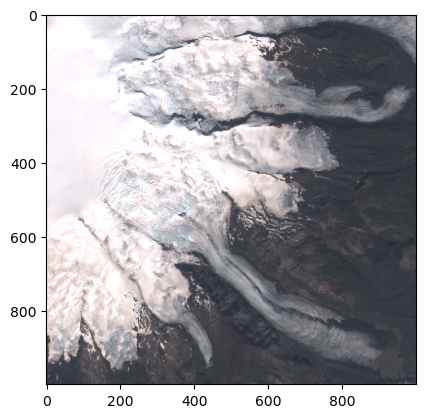

In [34]:
# Read the patch files
band2 = rasterio.open(f"{Path.home()}/patch_band_2.jp2", driver="JP2OpenJPEG")  # blue
band3 = rasterio.open(f"{Path.home()}/patch_band_3.jp2", driver="JP2OpenJPEG")  # green
band4 = rasterio.open(f"{Path.home()}/patch_band_4.jp2", driver="JP2OpenJPEG")  # red

red = band4.read(1)
green = band3.read(1)
blue = band2.read(1)

# Normalize the pixel values and apply gain
gain =1.1
red_n = np.clip(red * gain / 10000, 0, 1)
green_n = np.clip(green * gain / 10000, 0, 1)
blue_n = np.clip(blue * gain / 10000, 0, 1)

# Create composite image
rgb_composite_n = np.dstack((red_n, green_n, blue_n))

# Display image
plt.imshow(rgb_composite_n)

# Save image to file
matplotlib.image.imsave(f"{Path.home()}/Sentinel2_true_color.jpeg", rgb_composite_n)
print("Saved as:", outfile)

####
#### Explore the CDSE Documentation to learn more about the available APIs and services:
#### https://documentation.dataspace.copernicus.eu/Home.html